# Cannabis Brand Sales Forecaster

Predictive Model for Sales Forecasting & Inferring Key Factors in Brand Success

Predicts Total Sales in USD ($) based on products sold, prior month sales/ARP time series data, and other features

## Table of Contents/ Bookmarks

<a href=#dataclean>Data Cleaning</a>

<a href=#test_augments>Test/Design Augments</a>

<a href=#feature_extract_plan>Feature Extraction Plan [4] </a>

<a href=#augments>Augment & Merge Data [1 & 2 & 4]</a>

<a href=#basicstats>Basic Statistics [3]</a>

<a href=#datapipeline>Data Pipeline [5]</a>

Data Strategy [6]: **TBD**

<a href=#linreg>Linear Regression Model [7]</a>

<a href=#pca>PCA [8]</a>

<a href=#ensemble>Ensemble Model [9]</a>

<a href=#crossval>Cross-Validation (LinReg & Ensemble) [10]</a>

GridSearch Parameter Optimization [11]: **TBD**

Experimentation/ Highest Performing Model [12]: **TBD**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
retprice = pd.read_csv('data/BrandAverageRetailPrice.csv')
dets = pd.read_csv('data/BrandDetails.csv')
sales = pd.read_csv('data/BrandTotalSales.csv')
units = pd.read_csv('data/BrandTotalUnits.csv')

In [4]:
#check how big the data should be after merging --> looks like sales has the least data (since length of merges matches sales), and the other frames contain all brand/month points that sales does
#-->will grab unique brands from sales for later looping and make sure length of the my augmented data is still 25279
test = units.merge(sales, left_on = ["Brands", 'Months'], right_on = ['Brand', 'Months'])
test = test.merge(retprice, left_on = ["Brand", 'Months'], right_on = ['Brands', 'Months'])
len(test)

25279

<a id = 'dataclean'></a>

# Data Cleaning

## Clean up the data

In [5]:
units.head()
sales.head()

,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Months           25279 non-null  object
 1   Brand            25279 non-null  object
 2   Total Sales ($)  25279 non-null  object
dtypes: object(3)
memory usage: 592.6+ KB


In [7]:
#Convert sales data to useful data types
sales.loc[:, 'Months'] = pd.to_datetime(sales['Months'])
#grab first 8 string chars dropping commas, convert to float
sales.loc[:, 'Total Sales ($)'] = sales['Total Sales ($)'].str.replace(',', '')
sales.loc[:, 'Total Sales ($)'] = sales['Total Sales ($)'].str[:8]
sales.loc[:, 'Total Sales ($)'] = pd.to_numeric(sales['Total Sales ($)'])
#rename Brand column from sales
sales.rename(columns = {'Brand':'Brands'}, inplace = True)
sales.head()

,Months,Brands,Total Sales ($)
0,2018-09-01,10x Infused,1711.334
1,2018-09-01,1964 Supply Co.,25475.210
2,2018-09-01,3 Bros Grow,120153.600
3,2018-09-01,3 Leaf,6063.529
4,2018-09-01,350 Fire,631510.000


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brands           25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


In [9]:
#Convert units data to useful data types
units.loc[:, 'Months'] = pd.to_datetime(units['Months'])
#grab first 8 string chars dropping commas, convert to float
units.loc[:, 'Total Units'] = units['Total Units'].str.replace(',', '').str[:8]
units.loc[:, 'Total Units'] = pd.to_numeric(units['Total Units'])
units.head()

,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,2020-08-01,1616.3390,NaN
1,#BlackSeries,2020-09-01,NaN,-1.000000
2,#BlackSeries,2021-01-01,715.5328,NaN
3,#BlackSeries,2021-02-01,766.6691,0.071466
4,#BlackSeries,2021-03-01,NaN,-1.000000


In [10]:
units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Brands            27686 non-null  object        
 1   Months            27686 non-null  datetime64[ns]
 2   Total Units       25712 non-null  float64       
 3   vs. Prior Period  24935 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 865.3+ KB


In [11]:
#convert retprice data to useful data types
retprice.loc[:, 'Months'] = pd.to_datetime(retprice['Months'])

In [12]:
retprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27211 entries, 0 to 27210
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Brands            27211 non-null  object        
 1   Months            27211 non-null  datetime64[ns]
 2   ARP               25279 non-null  float64       
 3   vs. Prior Period  24499 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 850.5+ KB


In [13]:
def convert_data_types(sales, units, retprice):
    #Convert sales data to useful data types
    sales.loc[:, 'Months'] = pd.to_datetime(sales['Months'])
    #grab first 8 string chars dropping commas, convert to float
    sales.loc[:, 'Total Sales ($)'] = sales['Total Sales ($)'].str.replace(',', '').str[:8]
    sales.loc[:, 'Total Sales ($)'] = pd.to_numeric(sales['Total Sales ($)'])
    #rename Brand column from sales
    sales.rename(columns = {'Brand':'Brands'}, inplace = True)
    
    #Convert units data to useful data types
    units.loc[:, 'Months'] = pd.to_datetime(units['Months'])
    #grab first 8 string chars dropping commas, convert to float
    units.loc[:, 'Total Units'] = units['Total Units'].str.replace(',', '').str[:8]
    units.loc[:, 'Total Units'] = pd.to_numeric(units['Total Units'])
    
    #convert retprice data to useful data types
    retprice.loc[:, 'Months'] = pd.to_datetime(retprice['Months'])
    
    return (sales, units, retprice)

def merge_data(sales, units, retprice):
        
    merged = sales.merge(units, how = 'inner', left_on=['Brands', 'Months'], right_on = ['Brands', 'Months'])
    merged = merged.merge(retprice, how = 'inner', left_on=['Brands', 'Months'], right_on = ['Brands', 'Months'])

    #correct weird labeling
    merged.rename(columns={"vs. Prior Period_x": "Units Moved vs. Prior Period", "vs. Prior Period_y": "ARP vs. Prior Period"}, inplace = True)
    
    return merged

In [14]:
data = merge_data(sales, units, retprice)

<a id='test_augments'></a>


## Design/ Test Augments

### Note: Some of this work is outdated compared to the work when looping through all brands, because the loop introduced errors/ efficiency problems

Time series feature augmentation) Previous month unit sales, rolling 3 month average unit sale, average unit movement increase over previous 3 months.

Other feature augmentation) Number of products offered, edibles offered Y/N, inhaleables offered Y/N, primary product offered (inhaleables or edibles)

In [15]:
#market augments, grab total market size time series

sales.head()

def market_augments(sales):
    # Calculates total market value for each time (Later used for 'Market Share (%)')
    dates = sales["Months"].unique()
    totalShareByDate = list()
    for date in dates:
        tot = 0
        for i in sales.index:
            if date == sales['Months'][i]:
                tot = tot + sales['Total Sales ($)'][i]
        totalShareByDate.append(tot)

    # Creates dataframe with market size at each time (Later used for 'Market Share (%)')
    d = {'Time':dates,'Total Share ($)':totalShareByDate}
    marketsize = pd.DataFrame(data=d)
    return marketsize

marketsize = market_augments(sales)


In [16]:
testbrand = units[units.Brands == '101 Cannabis Co.'].copy()
#testbrand.head(100)

#UNITS TIME SERIES AUGMENTATION
#inserting new column with # of units moved in previous month
testbrand.loc[:,'Units Moved Previous Month'] = testbrand.loc[:,'Total Units'].shift(1)

#inserting another column with difference rolling average of last three months vals
testbrand.loc[:,'3 Prev. Month Units Moved Avg.'] = (testbrand.loc[:,'Total Units'].shift(1) + testbrand.loc[:,'Total Units'].shift(2) + testbrand.loc[:,'Total Units'].shift(3))/3

#inserting average unit movement growth
testbrand.loc[:,'Average 3 Mo. Units Growth'] = ((testbrand.loc[:,'Total Units'].shift(1) - testbrand.loc[:,'Total Units'].shift(2)) + (testbrand.loc[:,'Total Units'].shift(2) - testbrand.loc[:,'Total Units'].shift(3))) / 2

#merge with sales data
testbrand = testbrand.merge(sales, left_on=['Brands', 'Months'], right_on = ['Brands', 'Months'])
#testbrand.head(100)


#MARKET SHARE TIME SERIES AUGMENTATION
#grab datetime values
datetimes = pd.DatetimeIndex(testbrand['Months'])
display(datetimes)

# Insert new column with the year
testbrand['Year'] = datetimes.year

# Insert new column with the quarter of the fiscal year
bins = [0,3,6,9,12] # Creates a new bin for every 3 months
labels = [1,2,3,4] # Q1, Q2, ...
testbrand['Quarter'] = pd.cut(datetimes.month, bins, labels=labels)

# Insert new column with length of time in market
testbrand['Length_In_Market'] = testbrand.loc[:,'Months'] - datetimes[0]

# Insert new column with market share ('Total Sales of 'brand' at _date_' / 'Total sales of industry at _date_')
dates = testbrand["Months"].unique()
temp = list()

#generate a list of market shares for each brand:
for i in testbrand.index: # For every row in testbrand
    for date in dates:  # For every date in the data
        if date == testbrand['Months'][i]:  # If the date is the same as that of the current row, calculate market share
            totalMarket = marketsize[marketsize.Time == testbrand.loc[i, 'Months']]
            totalMarket = totalMarket.iloc[0]['Total Share ($)']
            temp.append(testbrand.loc[i, 'Total Sales ($)'] / totalMarket)
            break

#insert these market shares
testbrand['Market Share (%)'] = temp

# Insert new column with last month's total units
testbrand.loc[:,'Previous Month (Market Share)'] = testbrand.loc[:,'Market Share (%)'].shift(1)

# Insert new column with average market share over last 3 months
testbrand.loc[:,'Rolling Average (Market Share)'] = (testbrand.loc[:,'Market Share (%)'].shift(1) + testbrand.loc[:,'Market Share (%)'].shift(2) + testbrand.loc[:,'Market Share (%)'].shift(3))/3



#testbrand.info()


#testbrand.head(10)

testdets = dets[dets.Brand == '101 Cannabis Co.']
#testdets.head()

#add features for edibles/ inhaleables
edibles = 0
inhaleables = 0
if 'Edibles' in testdets['Category L1'].values:
    edibles = 1
if 'Inhaleables' in testdets['Category L1'].values:
    inhaleables = 1
testbrand['Sells Ingestibles'] = edibles
testbrand['Sells Inhaleables'] = inhaleables

#add a categorical for the majority product
edibles_ct = 0
inhaleables_ct = 0
try:
    edibles_ct = testdets['Category L1'].value_counts()['Edibles']
except KeyError:
    edibles_ct = 0
try:
    inhaleables_ct = testdets['Category L1'].value_counts()['Inhaleables']
except KeyError:
    edibles_ct = 0

majority = np.nan
if inhaleables_ct == edibles_ct:
    majority = 'Tie'
elif inhaleables_ct > edibles_ct:
    majority = 'Inhaleables'
else:
    majority = 'Edibles'

testbrand.loc[:, 'Product Majority'] = majority

#add other brand detail features
# Feature Extraction from 'Category L2'
value2 = 0
value3 = 0
if 'Concentrates' in testdets['Category L2'].values:
    value2 = 1
if 'Pre-Rolled' or 'Flower' in testdets['Category L2'].values:
    value3 = 1
# Feature Extraction from 'Category L4'
value4 = 0
if 'Vape Cartridge' in testdets['Category L4'].values:
    value4 = 1
# Feature Extraction from 'Total THC'
value5 = 1
if 0 in testdets['Total THC'].values:
    value5 = 0
# Feature Extraction from 'Total CBD'
value6 = 1
if 0 in testdets['Total CBD'].values:
    value6 = 0
# Add all augmented features to df
testbrand.loc[:,'Concentrates'] = value2
testbrand.loc[:,'Pre-Rolled/Flower'] = value3
testbrand.loc[:,'Vape Cartridge'] = value4
testbrand.loc[:,'Sells THC'] = value5
testbrand.loc[:,'Sells CBD'] = value6


#testbrand.head()

productcount = (testdets.Brand == '101 Cannabis Co.').count()
productcount

testbrand['NumProducts'] = productcount

#testbrand.head()

#retprice.head()

#going to augment with the change in average retail price over the previous 2 months
testret = retprice[retprice.Brands == '101 Cannabis Co.']

#merge with ARP data
testbrand = testbrand.merge(testret, left_on=['Brands', 'Months'], right_on = ['Brands', 'Months'])
testbrand.loc[:, 'ARP Increase Previous 2 Months ($)'] = testbrand.loc[:, 'ARP'].shift(1) - testbrand.loc[:, 'ARP'].shift(2)
testbrand.head(100)


testbrand.drop(axis=1, labels = ['ARP'], inplace = True)
testbrand.rename(columns={"vs. Prior Period_x": "Units Moved vs. Prior Period", "vs. Prior Period_y": "ARP vs. Prior Period"}, inplace = True)


testbrand.head(15)

DatetimeIndex(['2019-11-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', name='Months', freq=None)

,Brands,Months,Total Units,Units Moved vs. Prior Period,Units Moved Previous Month,3 Prev. Month Units Moved Avg.,Average 3 Mo. Units Growth,Total Sales ($),Year,Quarter,Length_In_Market,Market Share (%),Previous Month (Market Share),Rolling Average (Market Share),Sells Ingestibles,Sells Inhaleables,Product Majority,Concentrates,Pre-Rolled/Flower,Vape Cartridge,Sells THC,Sells CBD,NumProducts,ARP vs. Prior Period,ARP Increase Previous 2 Months ($)
0,101 Cannabis Co.,2019-11-01,131.0677,NaN,NaN,NaN,NaN,4465.040,2019,4,0 days,0.000018,NaN,NaN,0,1,Inhaleables,1,1,0,1,1,77,NaN,NaN
1,101 Cannabis Co.,2020-01-01,345.4134,NaN,NaN,NaN,NaN,11790.660,2020,1,61 days,0.000048,0.000018,NaN,0,1,Inhaleables,1,1,0,1,1,77,NaN,NaN
2,101 Cannabis Co.,2020-02-01,696.6584,1.016883,345.4134,NaN,NaN,20266.760,2020,1,92 days,0.000083,0.000048,NaN,0,1,Inhaleables,1,1,0,1,1,77,-0.147753,0.068263
3,101 Cannabis Co.,2020-03-01,943.3933,0.354169,696.6584,NaN,NaN,30465.470,2020,1,121 days,0.000111,0.000083,0.000050,0,1,Inhaleables,1,1,0,1,1,77,0.110071,-5.043541
4,101 Cannabis Co.,2020-04-01,712.4981,-0.244750,943.3933,661.821700,298.98995,23465.650,2020,2,152 days,0.000093,0.000111,0.000081,0,1,Inhaleables,1,1,0,1,1,77,0.019844,3.202110
5,101 Cannabis Co.,2020-05-01,619.8410,-0.130045,712.4981,784.183267,7.91985,21348.390,2020,2,182 days,0.000074,0.000093,0.000095,0,1,Inhaleables,1,1,0,1,1,77,0.045769,0.640846
6,101 Cannabis Co.,2020-06-01,426.1504,-0.312484,619.8410,758.577467,-161.77615,14111.750,2020,2,213 days,0.000048,0.000074,0.000092,0,1,Inhaleables,1,1,0,1,1,77,-0.038535,1.507381
7,101 Cannabis Co.,2020-07-01,589.7193,0.383829,426.1504,586.163167,-143.17385,18948.510,2020,3,243 days,0.000057,0.000048,0.000072,0,1,Inhaleables,1,1,0,1,1,77,-0.029688,-1.327228
8,101 Cannabis Co.,2020-08-01,1018.5740,0.727218,589.7193,545.236900,-15.06085,32743.470,2020,3,274 days,0.000095,0.000057,0.000060,0,1,Inhaleables,1,1,0,1,1,77,0.000466,-0.983090
9,101 Cannabis Co.,2020-09-01,1408.8500,0.383160,1018.5740,678.147900,296.21180,44839.680,2020,3,305 days,0.000136,0.000095,0.000067,0,1,Inhaleables,1,1,0,1,1,77,-0.009931,0.014974


<a id='augments'></a>


# Augment & Merge Data (Time Series + Details Augments)
## (1 & 2 & 4)

In [17]:
#my pipeline for augments
#note that ties on majority product and some other augmented info can result from a lack of match in the brand details dataframe! Brand details does not cover all brands..

def augment_data(data, dets, marketsize):
    brand_frames = []
    
    brands = data["Brands"].unique()
    
    for brand in brands:
        
        singlebrand = data[data.Brands == brand].copy()
        if len(singlebrand) == 0:
            continue
            
        #GRAB BRAND DETAILS
        singledets = dets[dets.Brand == brand]
        
        
        #UNIT AUGMENTS
        #inserting new column with # of units moved in previous month
        singlebrand.loc[:,'Units Moved Previous Month'] = singlebrand.loc[:,'Total Units'].shift(1)
        #inserting another column with difference rolling average of last three months vals
        singlebrand.loc[:,'3 Prev. Month Units Moved Avg.'] = (singlebrand.loc[:,'Total Units'].shift(1) + singlebrand.loc[:,'Total Units'].shift(2) + singlebrand.loc[:,'Total Units'].shift(3))/3
        #inserting average unit movement growth
        singlebrand.loc[:,'Average 3 Mo. Units Growth'] = ((singlebrand.loc[:,'Total Units'].shift(1) - singlebrand.loc[:,'Total Units'].shift(2)) + (singlebrand.loc[:,'Total Units'].shift(2) - singlebrand.loc[:,'Total Units'].shift(3))) / 2
        
        #add features for edibles/ inhaleables
        edibles = 0
        inhaleables = 0
        if 'Ingestibles' in singledets['Category L1'].values:
            edibles = 1
        if 'Inhaleables' in singledets['Category L1'].values:
            inhaleables = 1
        singlebrand['Sells Ingestibles'] = edibles
        singlebrand['Sells Inhaleables'] = inhaleables

        #add a categorical for the majority product
        edibles_ct = 0
        inhaleables_ct = 0
        try:
            edibles_ct = singledets['Category L1'].value_counts()['Edibles']
        except KeyError:
            edibles_ct = 0
        try:
            inhaleables_ct = singledets['Category L1'].value_counts()['Inhaleables']
        except KeyError:
            edibles_ct = 0

        majority = np.nan
        if inhaleables_ct == edibles_ct:
            majority = 'Tie'
        elif inhaleables_ct > edibles_ct:
            majority = 'Inhaleables'
        else:
            majority = 'Edibles'

        singlebrand.loc[:, 'Product Majority'] = majority

        #add other brand detail features
        # Feature Extraction from 'Category L2'
        value2 = 0
        value3 = 0
        if 'Concentrates' in singledets['Category L2'].values:
            value2 = 1
        if 'Pre-Rolled' in singledets['Category L2'].values or 'Flower' in singledets['Category L2'].values:
            value3 = 1
        # Feature Extraction from 'Category L4'
        value4 = 0
        if 'Vape Cartridge' in singledets['Category L4'].values:
            value4 = 1
        # Feature Extraction from 'Total THC' --> are there any THC contents nonzero?
        value5 = 0
        if np.any(singledets['Total THC'].values):
            value5 = 1
        # Feature Extraction from 'Total CBD' --> are there any CBD contents nonzero?
        value6 = 0
        if np.any(singledets['Total CBD'].values):
            value6 = 1
        # Add rest of augmented features to df
        singlebrand.loc[:,'Concentrates'] = value2
        singlebrand.loc[:,'Pre-Rolled/Flower'] = value3
        singlebrand.loc[:,'Vape Cartridge'] = value4
        singlebrand.loc[:,'Sells THC'] = value5
        singlebrand.loc[:,'Sells CBD'] = value6
        
        #Add number of products offered
        productcount = (singledets.Brand == brand).count()
        productcount

        singlebrand['NumProducts'] = productcount

    
        #ARP  AUGMENTS
        singlebrand.loc[:, 'ARP Increase Previous 2 Months ($)'] = singlebrand.loc[:, 'ARP'].shift(1) - singlebrand.loc[:, 'ARP'].shift(2)
        
        
        #ADD MORE COMPLEX TIME SERIES AUGMENTS
        #grab datetime values
        datetimes = pd.DatetimeIndex(singlebrand['Months'])

        # Insert new column with the year
        singlebrand['Year'] = datetimes.year

        # Insert new column with the quarter of the fiscal year
        bins = [0,3,6,9,12] # Creates a new bin for every 3 months
        labels = [1,2,3,4] # Q1, Q2, ...
        singlebrand['Quarter'] = pd.cut(datetimes.month, bins, labels=labels)

        # Insert new column with length of time in market
        singlebrand['Length_In_Market'] = singlebrand.loc[:,'Months'] - datetimes[0]

        # Insert new column with market share ('Total Sales of 'brand' at _date_' / 'Total sales of industry at _date_')
        dates = singlebrand["Months"].unique()
        temp = list()

        #generate a list of market shares for each brand:
        for i in singlebrand.index: # For every row in singlebrand
            for date in dates:  # For every date in the data
                if date == singlebrand['Months'][i]:  # If the date is the same as that of the current row, calculate market share
                    totalMarket = marketsize[marketsize.Time == singlebrand.loc[i, 'Months']]
                    totalMarket = totalMarket.iloc[0]['Total Share ($)']
                    temp.append(singlebrand.loc[i, 'Total Sales ($)'] / totalMarket)
                    break

        #insert these market shares
        singlebrand['Market Share (%)'] = temp

        # Insert new column with last month's total units
        singlebrand.loc[:,'Previous Month (Market Share)'] = singlebrand.loc[:,'Market Share (%)'].shift(1)

        # Insert new column with average market share over last 3 months
        singlebrand.loc[:,'Rolling Average (Market Share)'] = (singlebrand.loc[:,'Market Share (%)'].shift(1) + singlebrand.loc[:,'Market Share (%)'].shift(2) + singlebrand.loc[:,'Market Share (%)'].shift(3))/3
        #Insert new column with % market share growth over previous 2 months
        singlebrand.loc[:, 'Market Share Growth (% of Market) Prev. 2 Mo.'] = singlebrand.loc[:,'Market Share (%)'].shift(1) - singlebrand.loc[:,'Market Share (%)'].shift(2)
        
        #add singlebrand to the frame to later be concat
        brand_frames.append(singlebrand)
    
    augmented_frame = pd.concat(objs = brand_frames, axis=0)
    
    #reset the index for clarity-not necessary
    augmented_frame.reset_index(drop=True, inplace=True)
    return augmented_frame
        
        

In [18]:
data = augment_data(data, dets, marketsize)

In [19]:
data.head()
len(data)

25279

<a id='feature_extract_plan'></a>


## Feature Extraction Plan Summary (4)

State: All 'California' (DROP)

Channel: All 'Licensed' (DROP)

Category L1: -> 3 features (2 categorical, 1 binary): Inhaleables included? Edibles Included? Majority Inhaleables or Edibles or Tie

Category L2: --> 2 binary features: Concentrates Included? Pre-rolls/Flower Included?
Split (Concentrates), (Pre-Rolled, Flower), other

Category L3: Too many categories (DROP)

Category L4: --> 1 binary feature: Vape Cartridges included?

Category L5: Too many null (DROP)

Brand: Use for linking datasets, categorical var

Product Description: All unique (DROP)

Total Sales($): TARGET VALUE (DROP for test data)

Total Units: --> 3 features: Units moved previous month, 3 mo units moved avg, average growth across previous 3 months units moved, DROP ORIGINAL FEATURE BC HIGHLY CORRELATED WITH TARGET, ALL ADDED FEATURES BASED ON PREVIOUS TIMES

ARP: --> Increase in ARP across previous two months

Flavor: Too many null (DROP)

Items Per Pack: Majority 0, meaningless (DROP)

Item Weight: Too many null (DROP)

Total THC: Majority 0, (0 vs other) -> FEATURE: THC Yes or No?

Total CBD: Majority 0, (0 vs other) -> FEATURE: CBD Yes or No? --> DROPPING BC COLLINEARITY WITH TOTAL THC at impute step

Contains CBD: REDUNDANT w/ above added features

Pax Filter: Too many null (DROP)

Strain: >5000 (5824) unique string values (DROP)

Mood Effect: 2 categories - Not Mood Specific, Mood Specific   --> seems pretty meaningless DROP

Generic Vendor: 2 categories - Non-Generic Vendor, Generic Vendor --> seems pretty meaningless DROP

Generic Items: 2 categories - Non-Generic Items, Generic Items --> seems pretty meaningless DROP

5 Dollar Price Increment: Could convert to numeric feature at end of range and divide into >30 and <30 since $30 is roughly the median --> pretty redundant with ARP so DROP

<a id='basicstats'></a>

# Basic Data Statistics (3)

-Visualize Data, Correct Errors, Drop Highly Correlated Target Features/ Highly Correlated Features, Imputation Plan 




array([[<AxesSubplot:title={'center':'Months'}>,
        <AxesSubplot:title={'center':'Total Sales ($)'}>,
        <AxesSubplot:title={'center':'Total Units'}>,
        <AxesSubplot:title={'center':'Units Moved vs. Prior Period'}>,
        <AxesSubplot:title={'center':'ARP'}>],
       [<AxesSubplot:title={'center':'ARP vs. Prior Period'}>,
        <AxesSubplot:title={'center':'Units Moved Previous Month'}>,
        <AxesSubplot:title={'center':'3 Prev. Month Units Moved Avg.'}>,
        <AxesSubplot:title={'center':'Average 3 Mo. Units Growth'}>,
        <AxesSubplot:title={'center':'Sells Ingestibles'}>],
       [<AxesSubplot:title={'center':'Sells Inhaleables'}>,
        <AxesSubplot:title={'center':'Concentrates'}>,
        <AxesSubplot:title={'center':'Pre-Rolled/Flower'}>,
        <AxesSubplot:title={'center':'Vape Cartridge'}>,
        <AxesSubplot:title={'center':'Sells THC'}>],
       [<AxesSubplot:title={'center':'Sells CBD'}>,
        <AxesSubplot:title={'center':'NumProducts

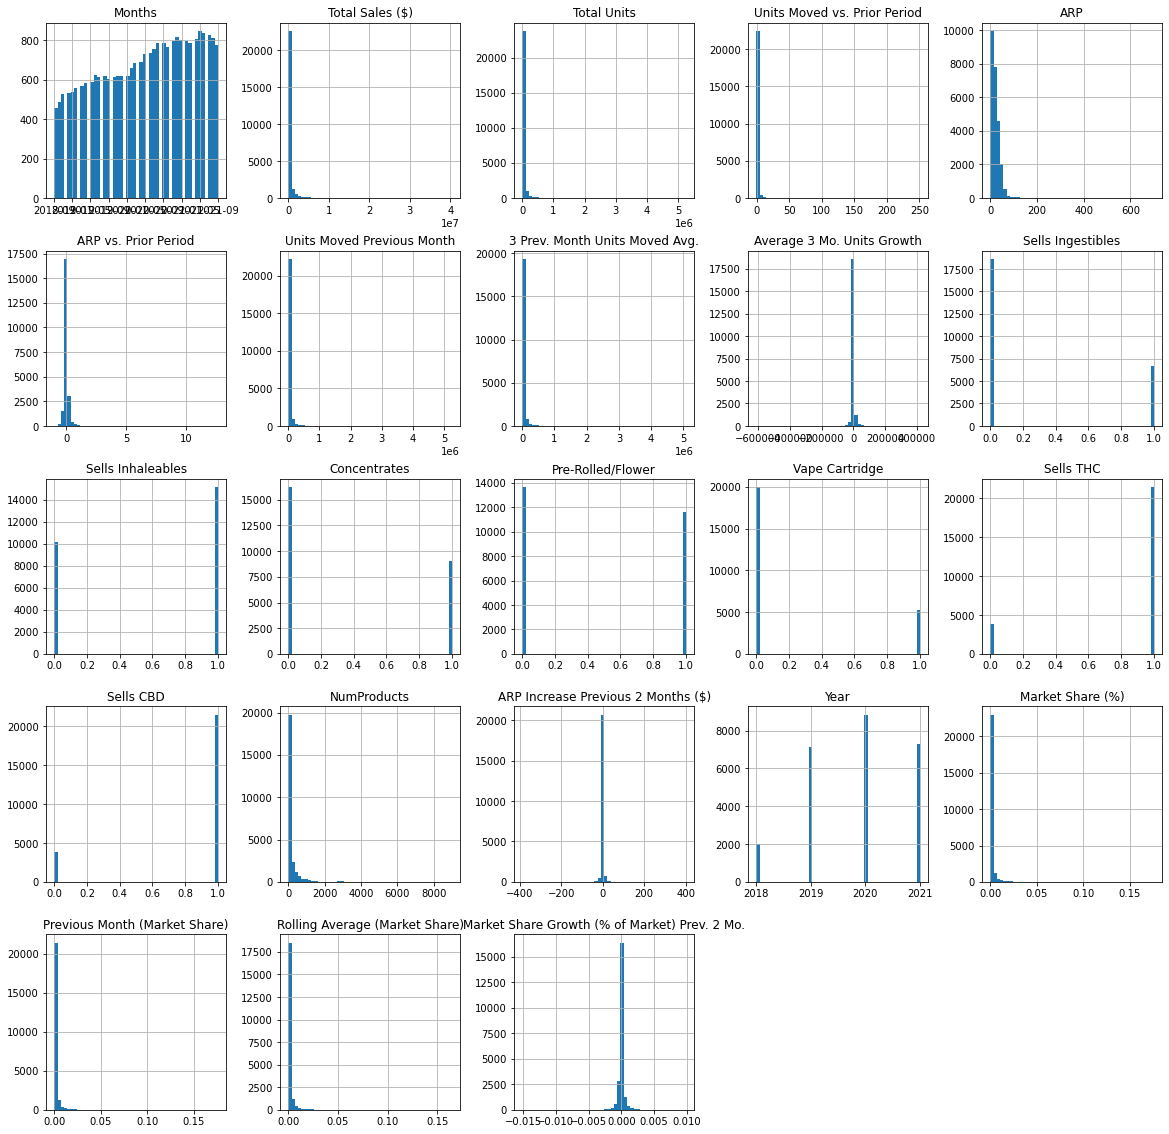

In [20]:
#corrected a number of small errors based on the below histogram
hist = data.hist(bins = 50, figsize = (20, 20))
display(hist)

<AxesSubplot:>

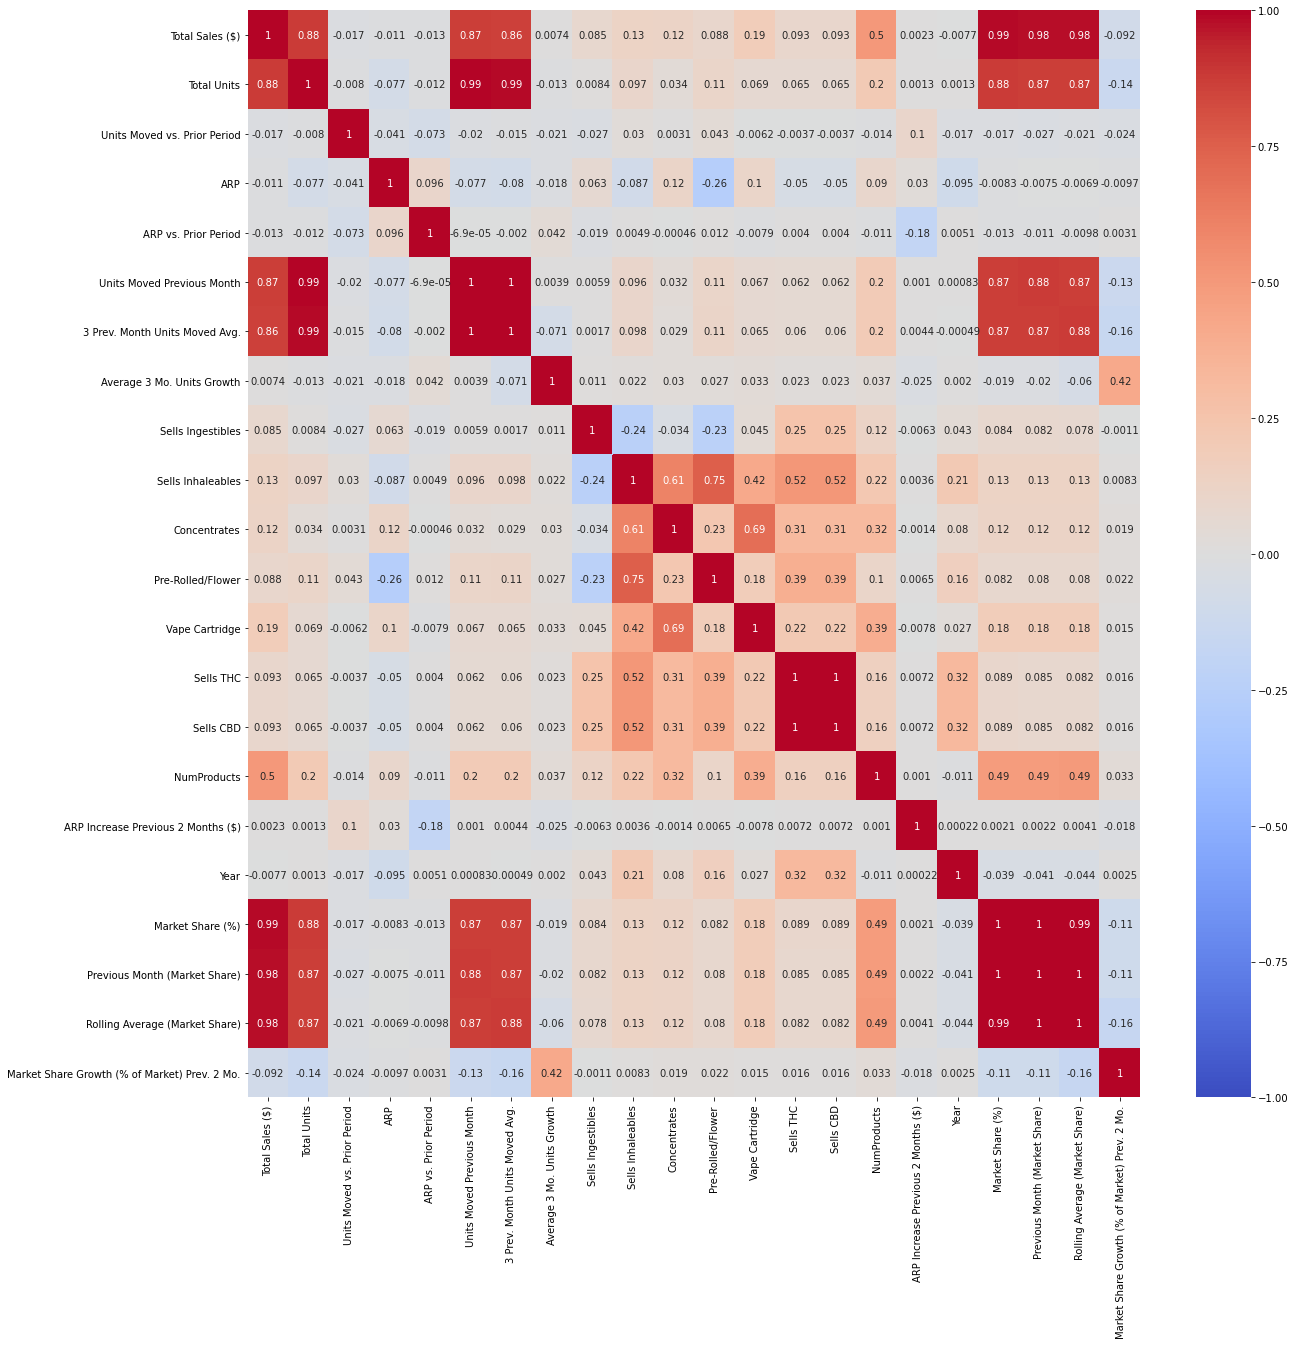

In [21]:
from matplotlib import rcParams
import seaborn as sns

# figure size in inches. Resized to fit on what would be a normal size page
rcParams['figure.figsize'] = 20, 20

sns.heatmap(data.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

In [22]:
data.info()
#data['Brands'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 27 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   Months                                         25279 non-null  datetime64[ns] 
 1   Brands                                         25279 non-null  object         
 2   Total Sales ($)                                25279 non-null  float64        
 3   Total Units                                    25279 non-null  float64        
 4   Units Moved vs. Prior Period                   22961 non-null  float64        
 5   ARP                                            25279 non-null  float64        
 6   ARP vs. Prior Period                           22570 non-null  float64        
 7   Units Moved Previous Month                     23652 non-null  float64        
 8   3 Prev. Month Units Moved Avg.                

 ### Correlation Drops & Imputations & One-Hot Encoding
 
FEATURE --> IMPUTATION STRATEGY/ DROPPING 

Brands --> DROP, too many unique values

Months --> DROP, extracted year and quarter already, cannot feed datetime to ML model

Year --> Retain as is

Quarter --> One hot encode

Product Majority --> One hot encoded and realized it was highly collinear with sells inhaleables, ingestibles, etc. --> DROPPING BC COLLINEARITY

Total Units -> Median but DROPPING bc too correlated with target

Units Moved vs. Prior Period -> Would impute with 0 but DROPPING bc too correlated with target

Units Moved Previous Month -> Would impute with median but DROPPING bc too correlated with target

3 Prev. Month Units Moved Avg. --> Would impute with mdian but DROPPING bc too correlated with target

Average 3 Mo. Units Growth -> Impute nulls with 0

Sells CBD --> DROPPING because collinearity with Sells THC

ARP -> Impute nulls with Median

ARP vs. Prior Period -> Impute nulls with 0

ARP Increase Previous 2 Months ($) -> Impute nulls with 0

Market Share (%) -> DROP because too correlated with sales

Market Share Growth (% of Market) Prev. 2 Mo. --> Impute nulls with 0


All features will later be scaled with StandardScaler()

In [23]:
def drops_imp_ohc(data):
    newdata = data.drop(axis = 1, labels = ['Product Majority', 'Brands', 'Months', 'Sells CBD', '3 Prev. Month Units Moved Avg.', 'Total Units', 'Units Moved vs. Prior Period', 'Units Moved Previous Month', 'Market Share (%)', 'Previous Month (Market Share)', 'Rolling Average (Market Share)'])
    newdata['Average 3 Mo. Units Growth'].fillna(0, inplace = True)
    newdata['ARP'].fillna(data['ARP'].median(), inplace = True)
    newdata['ARP vs. Prior Period'].fillna(0, inplace = True)
    newdata['ARP Increase Previous 2 Months ($)'].fillna(0, inplace = True)
    newdata['Market Share Growth (% of Market) Prev. 2 Mo.'].fillna(0, inplace = True)
    
    #One-hot encode dummy variables
    quarter_dummies = pd.get_dummies(newdata.Quarter, prefix='quarter')
    #majority_dummies = pd.get_dummies(newdata['Product Majority'], prefix = 'majority')
    
    newdata = pd.concat(objs = [newdata, quarter_dummies], axis=1)
    newdata = newdata.drop(axis = 1, labels = ['Quarter'])
    
    #Fix length in market to reflect days as integers
    newdata['Length In Market (Days)'] = newdata['Length_In_Market'] / np.timedelta64(1, 'D')
    newdata = newdata.drop(axis = 1, labels = ['Length_In_Market'])
    
    
    return newdata
        

In [24]:
data = drops_imp_ohc(data)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 19 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Total Sales ($)                                25279 non-null  float64
 1   ARP                                            25279 non-null  float64
 2   ARP vs. Prior Period                           25279 non-null  float64
 3   Average 3 Mo. Units Growth                     25279 non-null  float64
 4   Sells Ingestibles                              25279 non-null  int64  
 5   Sells Inhaleables                              25279 non-null  int64  
 6   Concentrates                                   25279 non-null  int64  
 7   Pre-Rolled/Flower                              25279 non-null  int64  
 8   Vape Cartridge                                 25279 non-null  int64  
 9   Sells THC                                      252

array([[<AxesSubplot:title={'center':'Total Sales ($)'}>,
        <AxesSubplot:title={'center':'ARP'}>,
        <AxesSubplot:title={'center':'ARP vs. Prior Period'}>,
        <AxesSubplot:title={'center':'Average 3 Mo. Units Growth'}>],
       [<AxesSubplot:title={'center':'Sells Ingestibles'}>,
        <AxesSubplot:title={'center':'Sells Inhaleables'}>,
        <AxesSubplot:title={'center':'Concentrates'}>,
        <AxesSubplot:title={'center':'Pre-Rolled/Flower'}>],
       [<AxesSubplot:title={'center':'Vape Cartridge'}>,
        <AxesSubplot:title={'center':'Sells THC'}>,
        <AxesSubplot:title={'center':'NumProducts'}>,
        <AxesSubplot:title={'center':'ARP Increase Previous 2 Months ($)'}>],
       [<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Market Share Growth (% of Market) Prev. 2 Mo.'}>,
        <AxesSubplot:title={'center':'quarter_1'}>,
        <AxesSubplot:title={'center':'quarter_2'}>],
       [<AxesSubplot:title={'center':'quarter_

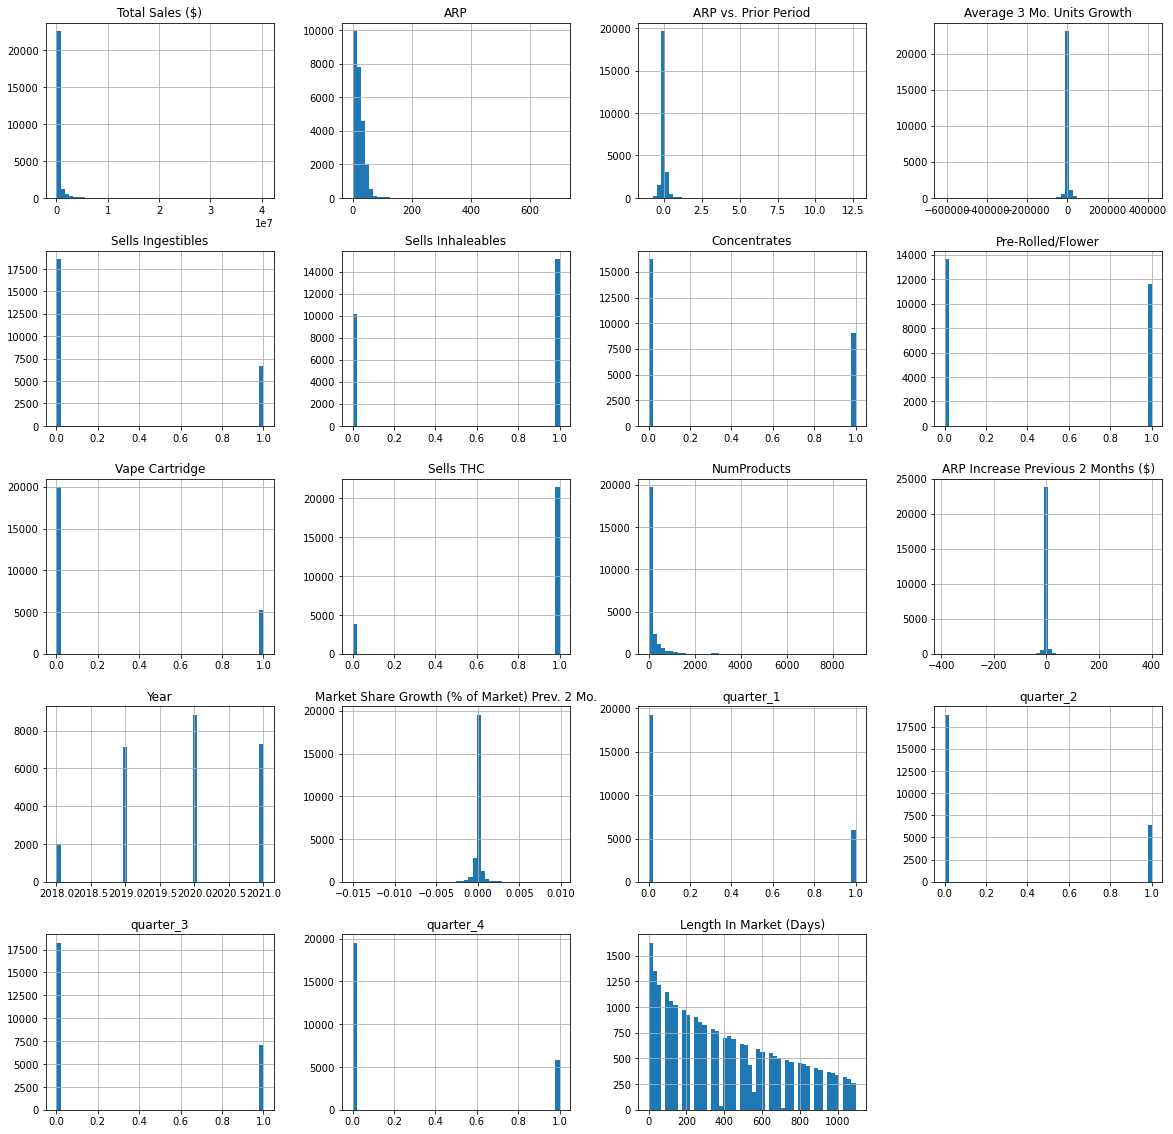

In [26]:
data.hist(bins = 50, figsize = (20, 20))

<AxesSubplot:>

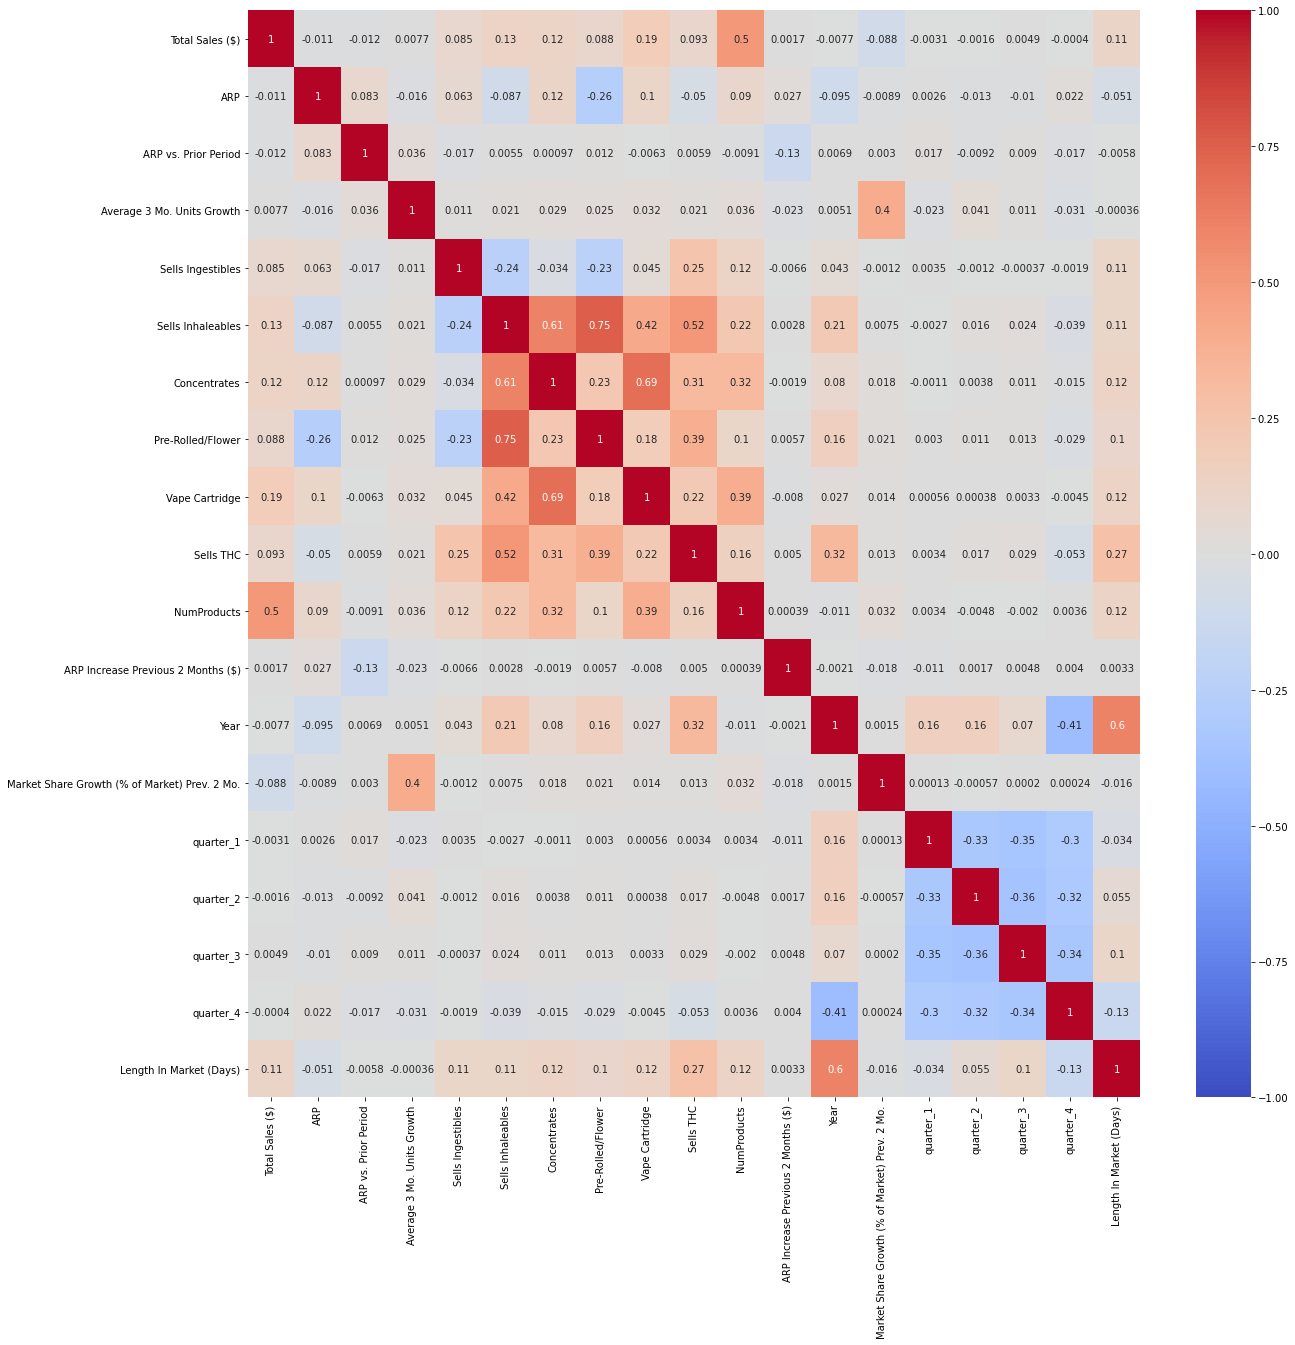

In [27]:
sns.heatmap(data.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

<a id='datapipeline'></a>
## Complete Data Pipeline (Compact) (5)


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#1) IMPORT DATA
retprice = pd.read_csv('data/BrandAverageRetailPrice.csv')
dets = pd.read_csv('data/BrandDetails.csv')
sales = pd.read_csv('data/BrandTotalSales.csv')
units = pd.read_csv('data/BrandTotalUnits.csv')

#2) CONVERT DATA TO USEFUL DATA TYPES & MERGE
converted = convert_data_types(sales, units, retprice)
sales = converted[0]
units = converted[1]
retprice = converted[2]
data = merge_data(sales, units, retprice)

#3) GET MARKET SIZE TIME SERIES FROM SALES
marketsize = market_augments(sales)

#4) AUGMENT DATA WITH TIME SERIES AUGMENTS, BRAND DETAIL DATA, ETC.
data = augment_data(data, dets, marketsize)

#5) PERFORM DROPS (COLLINEARITIES ETC.) & IMPUTATIONS & ONE-HOT ENCODING
data = drops_imp_ohc(data)

#6) SEPARATE TARGET
target = data['Total Sales ($)']
features = data.drop(axis = 1, labels = ['Total Sales ($)'])

#7) TRAIN TEST SPLIT (NEED TO DO BEFORE STANDARD SCALING SO AS NOT TO INTRODUCE MEAN/VAR OF TEST SET INTO MODELING)
#train test split with 15% test size
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.15, random_state = 0)
print(np.shape(x_train))
print(np.shape(x_test))

#8) PERFORM STANDARD SCALING
pip = Pipeline([('std_scaler', StandardScaler())])
x_train = pip.fit_transform(x_train)
x_test = pip.transform(x_test)


(21487, 18)
(3792, 18)


In [29]:
#used to double check the pipeline was working
#sns.heatmap(data.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

# Prep Data for ML

<a id='linreg'></a>
# Basic Linear Regression Model (7)

In [30]:
from sklearn.linear_model import LinearRegression

#After testing, running lin_reg with no fitting of the intercept greatly reduced model performance
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(x_train, y_train)


from sklearn.metrics import mean_absolute_error, r2_score

preds = lin_reg.predict(x_train)
mae = mean_absolute_error(y_train, preds)
r2 = r2_score(y_train, preds)

print('Sklearn Linear Regression)\n')

print("Train data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()

preds = lin_reg.predict(x_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Test data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()

coef_label = list(zip(lin_reg.coef_,list(features.columns)))
display(coef_label)

print()

#DETAILED P-VALUE ANALYSIS FOR PARAMETERS TO INFER FEATURE IMPORTANCE

import statsmodels.api as sm

lin_mod = sm.OLS(y_train, x_train)

#add the paramter names!
lin_mod.data.xnames = list(features.columns)

lin_mod = lin_mod.fit()
print(lin_mod.summary())

Sklearn Linear Regression)

Train data results:
MAE: 413814.1798857048
R2: 0.28183833766963295

Test data results:
MAE: 400273.63756215206
R2: 0.2261441753123905



[(-78122.67798188973, 'ARP'),
 (-4793.172230601684, 'ARP vs. Prior Period'),
 (49324.768837879055, 'Average 3 Mo. Units Growth'),
 (74059.80557743406, 'Sells Ingestibles'),
 (185307.93905681054, 'Sells Inhaleables'),
 (-165699.34043109434, 'Concentrates'),
 (-34844.05411849185, 'Pre-Rolled/Flower'),
 (29919.26553469034, 'Vape Cartridge'),
 (-31968.47976511874, 'Sells THC'),
 (813077.0358751923, 'NumProducts'),
 (3529.8262329294384, 'ARP Increase Previous 2 Months ($)'),
 (-129595.89348047003, 'Year'),
 (-210525.8034401154, 'Market Share Growth (% of Market) Prev. 2 Mo.'),
 (12454.488380432433, 'quarter_1'),
 (7297.123011821772, 'quarter_2'),
 (6313.627822793493, 'quarter_3'),
 (-26970.605306992395, 'quarter_4'),
 (143002.6788868372, 'Length In Market (Days)')]


                                 OLS Regression Results                                
Dep. Variable:        Total Sales ($)   R-squared (uncentered):                   0.265
Model:                            OLS   Adj. R-squared (uncentered):              0.264
Method:                 Least Squares   F-statistic:                              454.5
Date:                Wed, 01 Dec 2021   Prob (F-statistic):                        0.00
Time:                        15:32:38   Log-Likelihood:                     -3.3512e+05
No. Observations:               21487   AIC:                                  6.703e+05
Df Residuals:                   21470   BIC:                                  6.704e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----

**This basic linear regression has pretty mediocre/ bad performance, but it's bad between both the training and test sets, which indicates that its probably just a poor shape for the data.**

**Paramter Importance Interpretation:** TODO

<a id = 'pca'></a>
# PCA (8)

In [34]:
from sklearn.decomposition import PCA

#grab pre PCA data again
#7) TRAIN TEST SPLIT
#train test split with 15% test size
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.15, random_state = 0)
print(np.shape(x_train))
print(np.shape(x_test))

#8) PERFORM STANDARD SCALING
pip = Pipeline([('std_scaler', StandardScaler())])
x_train = pip.fit_transform(x_train)
x_test = pip.transform(x_test)

#make a PCA which accounts for 95% of the variance in the data
pca = PCA(.95)
pca.fit(x_train)

(21487, 18)
(3792, 18)


PCA(n_components=0.95)

In [36]:
#requires 14 of the components!
pca.n_components_

14

In [37]:
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [38]:
#Run linear regression again using PCA

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

preds = lin_reg.predict(x_train)
mae = mean_absolute_error(y_train, preds)
r2 = r2_score(y_train, preds)

print("PCA->LinReg Train data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()

preds = lin_reg.predict(x_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("PCA->LinReg Test data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()

PCA->LinReg Train data results:
MAE: 405572.7342179818
R2: 0.279130035864082

PCA->LinReg Test data results:
MAE: 390329.1072157023
R2: 0.22512235325208985



**PCA Does not improve performance of the linear regression model, but it does reduce dimensionality a bit by removing 4 features and retaining 95% of the variance**

<a id='ensemble'></a>
# Ensemble Method (XGBOOST) (9)

In [39]:
#grab pre-PCA data
#7) TRAIN TEST SPLIT
#train test split with 15% test size
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.15, random_state = 0)
print(np.shape(x_train))
print(np.shape(x_test))

#8) PERFORM STANDARD SCALING
pip = Pipeline([('std_scaler', StandardScaler())])
x_train = pip.fit_transform(x_train)
x_test = pip.transform(x_test)

#%pip install xgboost
import xgboost as xgb

#gamma, minimum loss reduction, could be added to prevent overfitting in the tree (would need to look at typical squared errors and find a cutoff point)
#with some testing, determined max depth of the gradient boost tree of 4 to perform best 
#across both training and testing sets for this particular data (will confirm best parameters with gridsearchCV later)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", booster = 'gbtree', max_depth = 4, random_state=42)

xgb_model.fit(x_train, y_train)

train_pred = xgb_model.predict(x_train)
test_pred = xgb_model.predict(x_test)

mae = mean_absolute_error(y_train, train_pred)
r2 = r2_score(y_train, train_pred)
print("XGBoost LinReg Train data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()

mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)
print("XGBoost LinReg Test data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()

(21487, 18)
(3792, 18)
XGBoost LinReg Train data results:
MAE: 134904.88477275532
R2: 0.971665127326807

XGBoost LinReg Test data results:
MAE: 174385.6918844599
R2: 0.911919860908177



**Wow, the XGBoost model is working quite well with the tuning I experimented with by hand. Hope to confirm via CV and find ideal parameters with GridSearch**

## XGBOOST & PCA Combined

In [40]:
#grab pre-PCA data
#7) TRAIN TEST SPLIT 
#train test split with 15% test size
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.15, random_state = 0)
print(np.shape(x_train))
print(np.shape(x_test))

#8) PERFORM STANDARD SCALING
pip = Pipeline([('std_scaler', StandardScaler())])
x_train = pip.fit_transform(x_train)
x_test = pip.transform(x_test)

#run the 95% variance PCA model
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

#retrain and run the same XGBOOST model on the PCA data

xgb_model.fit(x_train, y_train)

train_pred = xgb_model.predict(x_train)
test_pred = xgb_model.predict(x_test)

mae = mean_absolute_error(y_train, train_pred)
r2 = r2_score(y_train, train_pred)
print("XGBoost LinReg Train data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()

mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)
print("XGBoost LinReg Test data results:")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print()


(21487, 18)
(3792, 18)
XGBoost LinReg Train data results:
MAE: 173371.1371959483
R2: 0.9539428806961859

XGBoost LinReg Test data results:
MAE: 251364.51617389123
R2: 0.6652985015872956



**Again, PCA hurts model performance (Actually more here). Because we manually removed highly correlated data, PCA is not helpful for either of these models. It is possible PCA transformation on the data would improve performance on another model extremely sensitive to multicollinearities.**

<a id='crossval'></a>
# Stratified Cross-Validation

In [43]:
from sklearn.model_selection import StratifiedKFold

#bin total sales data into quartile categories so I can do a stratified split-->REMOVE BEFORE TRAINING/TESTING
(quartile_1, quartile_2, quartile_3, maximum) = np.percentile(data['Total Sales ($)'], q= [25,50,75,100])
print(f"Quartile 1 Monthly Total Sales: ${quartile_1}")
print(f"Quartile 2 Total Sales: ${quartile_2}")
print(f"Quartile 3 Total Sales: ${quartile_3}")
print(f"Maximum Total Sales: ${maximum}")
bins = [-1, quartile_1, quartile_2, quartile_3, maximum] # Creates bin edges for each quartile
labels = [1, 2, 3, 4]
data['Total Sales Quartile'] = pd.cut(data['Total Sales ($)'], bins=bins, labels=labels)

data.head()
data.info()

Quartile 1 Monthly Total Sales: $13903.195
Quartile 2 Total Sales: $62100.8
Quartile 3 Total Sales: $247326.95
Maximum Total Sales: $40363507.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Total Sales ($)                                25279 non-null  float64 
 1   ARP                                            25279 non-null  float64 
 2   ARP vs. Prior Period                           25279 non-null  float64 
 3   Average 3 Mo. Units Growth                     25279 non-null  float64 
 4   Sells Ingestibles                              25279 non-null  int64   
 5   Sells Inhaleables                              25279 non-null  int64   
 6   Concentrates                                   25279 non-null  int64   
 7   Pre-Rolled/Flower                              25

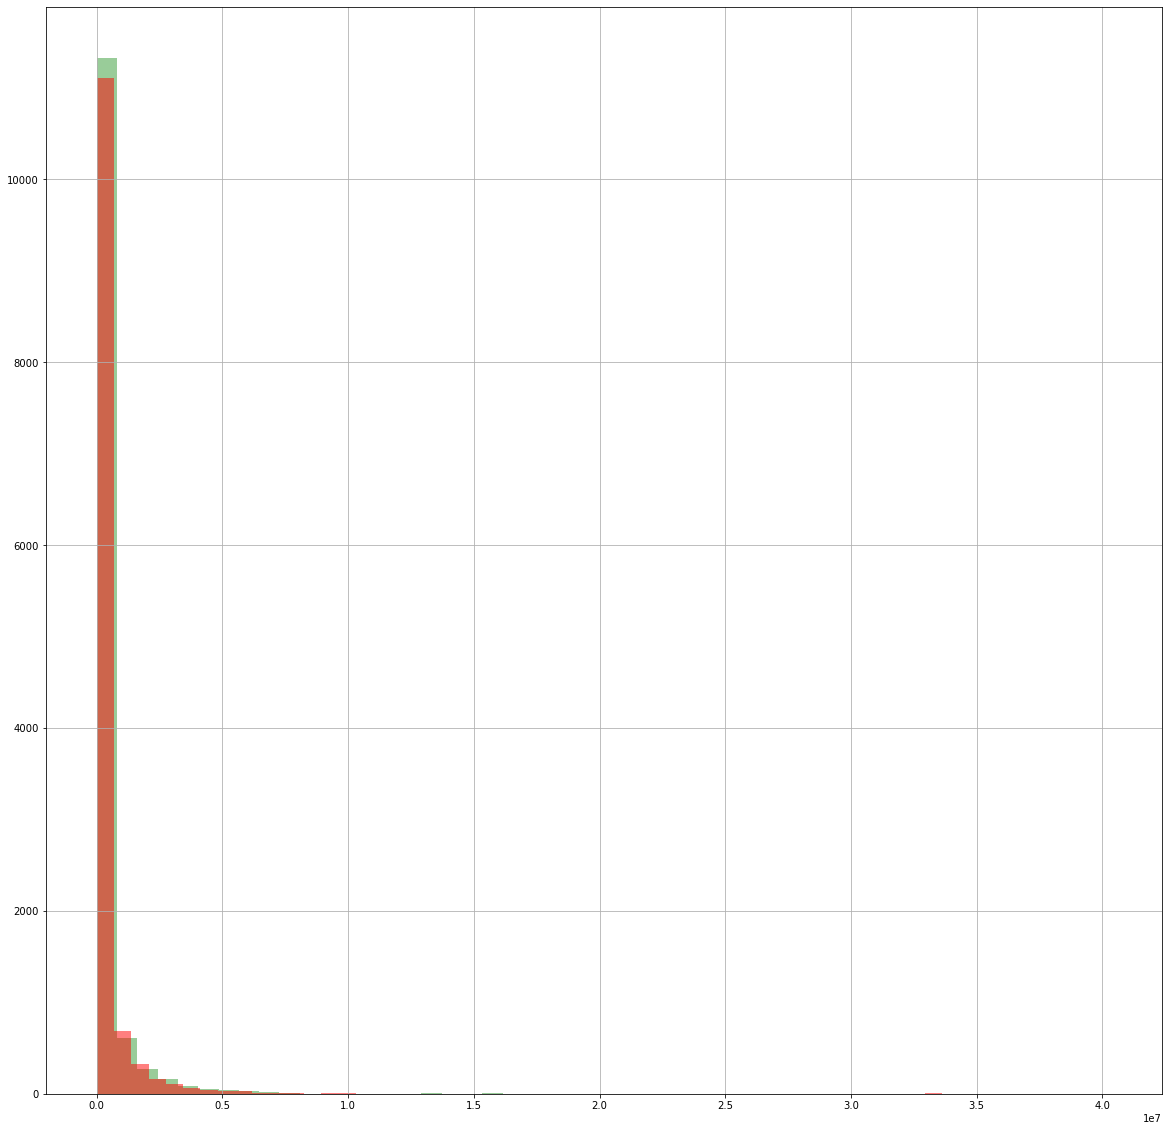

In [59]:
#now perform kfold cross-validation, stratified by total sales quartile
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

#arrays to hold metrics for CV of linreg and xgboost
linreg_maes = []
linreg_r2s = []
xgb_maes = []
xgb_r2s = []

#count = 0   #for stratification checking
for train_index, test_index in kfold.split(data, data['Total Sales Quartile']):
    #data finishes at step 5 of pipeline-> and now modified with added column for strat.
    
    #Step 6 & Step 7, split data, drop target
    train_set = data.loc[train_index].copy()
    test_set = data.loc[test_index].copy()
    
    cv_data_train = train_set.drop('Total Sales ($)', axis=1)
    cv_labels_train = train_set['Total Sales ($)']
    
    cv_data_test = test_set.drop('Total Sales ($)', axis=1)
    cv_labels_test = test_set['Total Sales ($)']
    
    #used to confirm that stratification was working properly, should be noted that most sales are low in the initial data set-> so strat.
    #was important, but the distribution here seems to match between testing and training set excellently!!
    #to check that the stratification was working I used an equal split between testing and training data (n_splits = 2)
    #if count == 0:
        #cv_labels_train.hist(bins = 50, color = 'green', alpha = 0.4)
        #cv_labels_test.hist(bins = 50, color = 'red', alpha = 0.5)
    #count +=1  #for stratification checking
    
    #DON'T LEAK THE TARGET VIA CATEGORY
    #drop the total sales categories!!
    cv_data_train = cv_data_train.drop('Total Sales Quartile', axis=1)
    cv_data_test = cv_data_test.drop('Total Sales Quartile', axis=1)
    
    #standardize data (Step 8 of pipeline, 1-7 already complete)
    pip = Pipeline([('std_scaler', StandardScaler())])
    cv_train_prep = pip.fit_transform(cv_data_train)
    cv_test_prep = pip.transform(cv_data_test)
    
    #CROSS-VALIDATE LINREG MODEL
    
    
    
    
    #CROSS-VALIDATE ENSEMBLE (XGBOOST) MODEL
    
    
    
    